Predict faces using trained model

In [29]:
import os
import pickle

from pathlib import Path
from typing import Dict, List, Tuple, Optional, Iterable

import numpy as np

import face_recognition

In [30]:
# =========================
# CẤU HÌNH ĐƯỜNG DẪN
# =========================
ROOT_DIR = Path.cwd()
DATA_DIR = ROOT_DIR / "data"
LFW_DIR = DATA_DIR / "lfw-deepfunneled" / "lfw-deepfunneled"
TRAIN_CSV = DATA_DIR / "peopleDevTrain.csv"
TEST_CSV = DATA_DIR / "peopleDevTest.csv"

MODEL_PATH = ROOT_DIR / "models" / "face_svc.pkl"
ENC_CACHE = ROOT_DIR / "models" / "train_encodings.pkl"

DEFAULT_TEST_DIR = ROOT_DIR / "test"
DEFAULT_TEST_OUT = ROOT_DIR / "models" / "test_results.csv"
DEFAULT_EVAL_FOLDER = ROOT_DIR / "test_100_peoples"

In [31]:
# =========================
# CẤU HÌNH FACE PIPELINE
# =========================
DETECT_MODEL = "hog"         # "hog" hoặc "cnn"
LANDMARKS_MODEL = "large"    # "small" hoặc "large"
UPSAMPLE = 0                # 0 nhanh, tăng lên (1,2) bắt mặt nhỏ tốt hơn nhưng chậm

In [32]:
# =========================
# LOAD ENCODINGS
# =========================
def load_enc_cache():
    """Load cache encodings nếu có."""
    if not ENC_CACHE.exists():
        return None
    try:
        with open(ENC_CACHE, "rb") as f:
            data = pickle.load(f)
        return data["X_train"], data["y_train"]
    except Exception:
        return None

In [33]:
# =========================
# TIỀN XỬ LÝ ẢNH / ENCODING
# =========================
def _box_area(box: Tuple[int, int, int, int]) -> int:
    """Tính diện tích box (top, right, bottom, left)."""
    top, right, bottom, left = box
    return max(0, bottom - top) * max(0, right - left)


def encode_image(
    image_path: str,
    detect_model: str = DETECT_MODEL,
    landmarks_model: str = LANDMARKS_MODEL,
    upsample: int = UPSAMPLE,
    choose_largest_face: bool = True
) -> Optional[np.ndarray]:
    """
    Đọc ảnh và trả về encoding đầu tiên (hoặc mặt lớn nhất nếu choose_largest_face=True).

    Pipeline:
    - Kiểm tra file
    - Load ảnh
    - Detect face locations (hog/cnn)
    - (Tuỳ chọn) chọn 1 mặt lớn nhất nếu có nhiều mặt
    - Face encodings (embedding 128D) với landmarks model (small/large)
    """
    if not os.path.isfile(image_path):
        print(f"[BỎ QUA] Không tìm thấy ảnh: {image_path}")
        return None

    try:
        image = face_recognition.load_image_file(image_path)
    except Exception as e:
        print(f"[BỎ QUA] Lỗi đọc ảnh: {image_path} | {e}")
        return None

    # 1) Detect mặt (bounding boxes)
    try:
        locs = face_recognition.face_locations(
            image,
            number_of_times_to_upsample=upsample,
            model=detect_model
        )
    except Exception as e:
        print(f"[BỎ QUA] Lỗi detect face: {image_path} | {e}")
        return None

    if not locs:
        print(f"[BỎ QUA] Không tìm thấy khuôn mặt trong ảnh: {image_path}")
        return None

    # 2) Nếu có nhiều mặt: chọn mặt lớn nhất (thường là chủ thể)
    if choose_largest_face and len(locs) > 1:
        locs = [max(locs, key=_box_area)]

    # 3) Tạo embedding 128D dựa trên locations đã biết
    try:
        encs = face_recognition.face_encodings(
            image,
            known_face_locations=locs,
            model=landmarks_model  # "small" hoặc "large"
        )
    except Exception as e:
        print(f"[BỎ QUA] Lỗi tạo encodings: {image_path} | {e}")
        return None

    if not encs:
        print(f"[BỎ QUA] Không tạo được encoding cho ảnh: {image_path}")
        return None

    return encs[0]

In [34]:
# =========================
# DỰ ĐOÁN ẢNH ĐƠN
# =========================
def predict_image(model_path: Path, image_path: str, unknown_threshold: float = 0.5):
    """Dự đoán nhãn cho một ảnh đơn lẻ (SVM + Unknown theo xác suất)."""
    if not os.path.isfile(model_path):
        raise FileNotFoundError(f"Chưa có model {model_path}, hãy train trước.")
    with open(model_path, "rb") as f:
        clf: SVC = pickle.load(f)

    enc = encode_image(image_path)
    if enc is None:
        return

    class_to_idx = {c: i for i, c in enumerate(clf.classes_)}
    pred_label = str(clf.predict([enc])[0])
    probs = clf.predict_proba([enc])[0]
    best_prob = float(probs[class_to_idx[pred_label]])

    if best_prob < unknown_threshold:
        print(f"Ảnh {image_path}: Unknown (conf={best_prob:.2f})")
        return {
            "image_path": image_path,
            "status": "Unknown",
            "svm_label": pred_label,
            "svm_conf": best_prob,
            "svm_unknown": True,
            "svm_threshold": unknown_threshold
        }
    else:
        print(f"Ảnh {image_path}: {pred_label} (conf={best_prob:.2f})")
        return {
            "image_path": image_path,
            "status": "Detected",
            "svm_label": pred_label,
            "svm_conf": best_prob,
            "svm_unknown": False,
            "svm_threshold": unknown_threshold
        }

In [35]:
# =========================
# DỰ ĐOÁN ẢNH ĐƠN THEO KHOẢNG CÁCH
# =========================
def predict_image_dist(image_path: str, distance_threshold: float = 0.6, top_k: int = 5):
    """
    Dự đoán bằng khoảng cách embedding (k-NN đơn giản).
    - Đọc cache encodings nếu có; nếu không sẽ build từ tập train.
    - Chọn nhãn có khoảng cách nhỏ nhất; nếu vượt ngưỡng -> Unknown.
    """
    enc = encode_image(image_path)
    if enc is None:
        return

    cache = load_enc_cache()
    if cache:
        print("[PRED-DIST] Đang dùng cache encodings.")
        X_train, y_train = cache
    else:
        print("[PRED-DIST] Đang tải tập train để so khớp khoảng cách (lâu)...")
        X_train, y_train = build_dataset(TRAIN_CSV)

    dists = np.linalg.norm(X_train - enc, axis=1)
    best_idx = int(np.argmin(dists))
    best_dist = float(dists[best_idx])
    best_label = y_train[best_idx]
    predict_result = None
    
    if best_dist > distance_threshold:
        print(f"Ảnh {image_path}: Unknown (dist={best_dist:.3f}, thr={distance_threshold})")
        result = {
            "image_path": image_path,
            "status": "Unknown",
            "dist_label": best_label,
            "dist_distance": best_dist,
            "dist_unknown": True,
            "dist_threshold": distance_threshold
        }
    else:
        print(f"Ảnh {image_path}: {best_label} (dist={best_dist:.3f})")
        result = {
            "image_path": image_path,
            "status": "Detected",
            "dist_label": best_label,
            "dist_distance": best_dist,
            "dist_unknown": False,
            "dist_threshold": distance_threshold
        }
    
    if top_k > 1:
        top_idx = np.argsort(dists)[:top_k]
        print("[PRED-DIST] Top gần nhất:")
        for rank, idx in enumerate(top_idx, 1):
            print(f"  {rank}. {y_train[idx]} | dist={float(dists[idx]):.3f}")

    return result

In [38]:
# Set predict params
predict_threshold = 0.5
predict_dist_threshold = 0.6
topk = 5

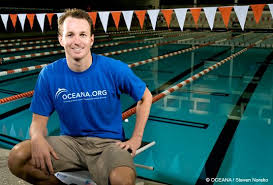

[BỎ QUA] Không tìm thấy khuôn mặt trong ảnh: C:\Users\PC-09\Documents\Projects\face_recognition_svm\test\1.jpg
[BỎ QUA] Không tìm thấy khuôn mặt trong ảnh: C:\Users\PC-09\Documents\Projects\face_recognition_svm\test\1.jpg


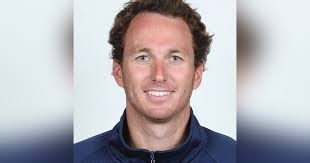

Ảnh C:\Users\PC-09\Documents\Projects\face_recognition_svm\test\2.jpg: Unknown (conf=0.00)
SVM Result:
image_path: C:\Users\PC-09\Documents\Projects\face_recognition_svm\test\2.jpg
status: Unknown
svm_label: Hugh_Grant
svm_conf: 0.0007973758292831654
svm_unknown: True
svm_threshold: 0.5
[PRED-DIST] Đang dùng cache encodings.
Ảnh C:\Users\PC-09\Documents\Projects\face_recognition_svm\test\2.jpg: Aaron_Peirsol (dist=0.397)
[PRED-DIST] Top gần nhất:
  1. Aaron_Peirsol | dist=0.397
  2. Aaron_Peirsol | dist=0.419
  3. Aaron_Peirsol | dist=0.439
  4. Aaron_Peirsol | dist=0.509
  5. Juan_Ignacio_Chela | dist=0.521
Distance Result:
image_path: C:\Users\PC-09\Documents\Projects\face_recognition_svm\test\2.jpg
status: Detected
dist_label: Aaron_Peirsol
dist_distance: 0.3970297110160313
dist_unknown: False
dist_threshold: 0.6


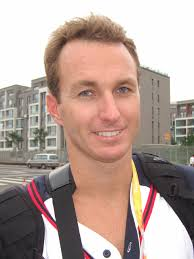

Ảnh C:\Users\PC-09\Documents\Projects\face_recognition_svm\test\3.jpg: Unknown (conf=0.00)
SVM Result:
image_path: C:\Users\PC-09\Documents\Projects\face_recognition_svm\test\3.jpg
status: Unknown
svm_label: Aaron_Peirsol
svm_conf: 0.00018927827421107857
svm_unknown: True
svm_threshold: 0.5
[PRED-DIST] Đang dùng cache encodings.
Ảnh C:\Users\PC-09\Documents\Projects\face_recognition_svm\test\3.jpg: Aaron_Peirsol (dist=0.396)
[PRED-DIST] Top gần nhất:
  1. Aaron_Peirsol | dist=0.396
  2. Aaron_Peirsol | dist=0.416
  3. Aaron_Peirsol | dist=0.452
  4. Aaron_Peirsol | dist=0.488
  5. Tommy_Robredo | dist=0.555
Distance Result:
image_path: C:\Users\PC-09\Documents\Projects\face_recognition_svm\test\3.jpg
status: Detected
dist_label: Aaron_Peirsol
dist_distance: 0.39556215429618335
dist_unknown: False
dist_threshold: 0.6


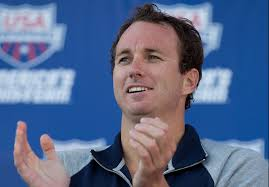

Ảnh C:\Users\PC-09\Documents\Projects\face_recognition_svm\test\4.jpg: Unknown (conf=0.00)
SVM Result:
image_path: C:\Users\PC-09\Documents\Projects\face_recognition_svm\test\4.jpg
status: Unknown
svm_label: Hugh_Grant
svm_conf: 0.0007855227631360812
svm_unknown: True
svm_threshold: 0.5
[PRED-DIST] Đang dùng cache encodings.
Ảnh C:\Users\PC-09\Documents\Projects\face_recognition_svm\test\4.jpg: Aaron_Peirsol (dist=0.416)
[PRED-DIST] Top gần nhất:
  1. Aaron_Peirsol | dist=0.416
  2. Aaron_Peirsol | dist=0.506
  3. Aaron_Peirsol | dist=0.519
  4. Aaron_Peirsol | dist=0.526
  5. Robert_F_Kennedy_Jr | dist=0.551
Distance Result:
image_path: C:\Users\PC-09\Documents\Projects\face_recognition_svm\test\4.jpg
status: Detected
dist_label: Aaron_Peirsol
dist_distance: 0.415702111537169
dist_unknown: False
dist_threshold: 0.6


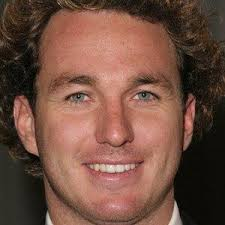

Ảnh C:\Users\PC-09\Documents\Projects\face_recognition_svm\test\5.jpg: Unknown (conf=0.00)
SVM Result:
image_path: C:\Users\PC-09\Documents\Projects\face_recognition_svm\test\5.jpg
status: Unknown
svm_label: Hugh_Grant
svm_conf: 0.0007688462690179073
svm_unknown: True
svm_threshold: 0.5
[PRED-DIST] Đang dùng cache encodings.
Ảnh C:\Users\PC-09\Documents\Projects\face_recognition_svm\test\5.jpg: Aaron_Peirsol (dist=0.457)
[PRED-DIST] Top gần nhất:
  1. Aaron_Peirsol | dist=0.457
  2. Aaron_Peirsol | dist=0.495
  3. Aaron_Peirsol | dist=0.507
  4. Aaron_Peirsol | dist=0.509
  5. Hugo_Colace | dist=0.538
Distance Result:
image_path: C:\Users\PC-09\Documents\Projects\face_recognition_svm\test\5.jpg
status: Detected
dist_label: Aaron_Peirsol
dist_distance: 0.457241039380423
dist_unknown: False
dist_threshold: 0.6


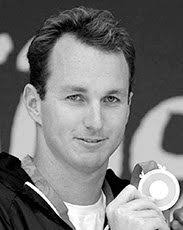

Ảnh C:\Users\PC-09\Documents\Projects\face_recognition_svm\test\6.jpg: Unknown (conf=0.00)
SVM Result:
image_path: C:\Users\PC-09\Documents\Projects\face_recognition_svm\test\6.jpg
status: Unknown
svm_label: Hugh_Grant
svm_conf: 0.0008344589439550591
svm_unknown: True
svm_threshold: 0.5
[PRED-DIST] Đang dùng cache encodings.
Ảnh C:\Users\PC-09\Documents\Projects\face_recognition_svm\test\6.jpg: Aaron_Peirsol (dist=0.356)
[PRED-DIST] Top gần nhất:
  1. Aaron_Peirsol | dist=0.356
  2. Aaron_Peirsol | dist=0.374
  3. Aaron_Peirsol | dist=0.408
  4. Aaron_Peirsol | dist=0.417
  5. Bode_Miller | dist=0.549
Distance Result:
image_path: C:\Users\PC-09\Documents\Projects\face_recognition_svm\test\6.jpg
status: Detected
dist_label: Aaron_Peirsol
dist_distance: 0.35596792758823026
dist_unknown: False
dist_threshold: 0.6


In [39]:
from PIL import Image
from IPython.display import display
import pandas as pd

for i in range(1, 7):
    image_path = os.path.join(DEFAULT_TEST_DIR, f"{i}.jpg")
    img = Image.open(image_path)
    display(img)

    # Predict by SVM
    predict_result = predict_image(MODEL_PATH, image_path, predict_threshold)
    if predict_result:
        print('SVM Result:')
        print('image_path:', predict_result['image_path'])
        print('status:', predict_result['status'])
        print('svm_label:', predict_result['svm_label'])
        print('svm_conf:', predict_result['svm_conf'])
        print('svm_unknown:', predict_result['svm_unknown'])
        print('svm_threshold:', predict_result['svm_threshold'])

    # Predict by embedding distance
    predict_dst_result = predict_image_dist(image_path, predict_dist_threshold, topk)
    if predict_dst_result:
        print('Distance Result:')
        print('image_path:', predict_dst_result['image_path'])
        print('status:', predict_dst_result['status'])
        print('dist_label:', predict_dst_result['dist_label'])
        print('dist_distance:', predict_dst_result['dist_distance'])
        print('dist_unknown:', predict_dst_result['dist_unknown'])
        print('dist_threshold:', predict_dst_result['dist_threshold'])
